In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")
sys.path.append("../../fdfdpy")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization
from utils import Binarizer

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.4e-1                 # grid size (L0)
NPML = [25, 25]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 20             # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
# max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L = 10         # length of box (L0)
H = 2        # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/2.44    # distance between waveguides (L0)
l = 4         # length of waveguide from PML to box (L0)
spc = 1.5       # space between box and PML (L0)

Computed a domain with 500 grids in x and 175 grids in y
The simulation has 50 grids per free space wavelength


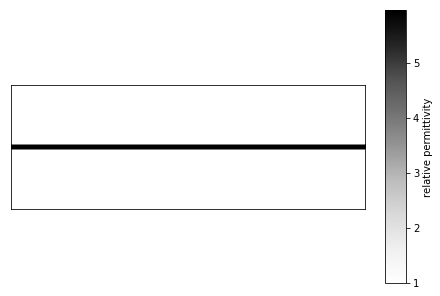

In [5]:
# define permittivity of three port system
eps_r, design_region = two_port(L, H, w, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [6]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(Ny/3), scale=source_amp)
simulation.setup_modes()

# top modal profile
out = Simulation(omega, eps_r, dl, NPML, 'Ez')
out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
out.setup_modes()
J_out = np.abs(out.src)

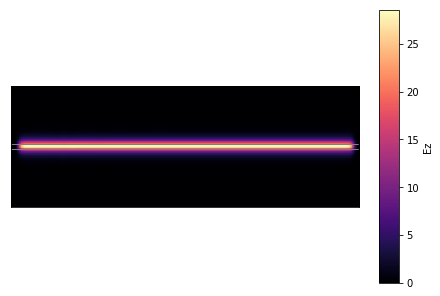

In [7]:
# set source and solve for electromagnetic fields
(_, _, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [8]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(Ny/3), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(Ny/3))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
J_out = J_out/SCALE
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

computed a scale of 1882.9316815633897 in units of E^2 J_out


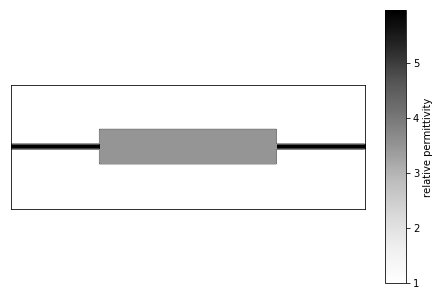

In [9]:
# changes design region. 'style' can be in {'full', 'empty', 'halfway', 'random'}
simulation.init_design_region(design_region, eps_m, style='halfway')
simulation.plt_eps()
plt.show()

In [10]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [11]:
# define objective function
import autograd.numpy as npa
def J(e, e_nl):
    linear_out =     1*npa.sum(npa.square(npa.abs(e))*J_out)
    nonlinear_out = -1*npa.sum(npa.square(npa.abs(e_nl))*J_out)
    return linear_out + nonlinear_out

In [12]:
# make optimization object and check derivatives
R = 5   # filter radius of curvature (pixels)  (takes a while to set up as R > 5-10)
beta = 100
eta= 0.5
optimization = Optimization(J=J, simulation=simulation, design_region=design_region, eps_m=eps_m, R=R, beta=beta, eta=eta)

 99% (437 of 439) |##################### | Elapsed Time: 0:01:25 ETA:   0:00:00

In [13]:
# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(Npts=5, d_rho=5e-4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [-1.0751792843648189e-05, -8.504147229734804e-05, 0.00013080167581856067, 2.320675066029565e-05, 2.6085098357372938e-05]
numerical gradient = [-1.0765044855531869e-05, -8.509942173162699e-05, 0.00013079714955566146, 2.3160104500874468e-05, 2.6060917202030964e-05]


In [14]:
new_eps = optimization.run(method='lbfgs', Nsteps=2000, step_size=2e-1)

 ObjectiveFn:  0.468 Iteration:  71/2000 ETA:   7:15:57                        

the simulation did not converge, reached 0.16312810492398028
the simulation did not converge, reached 0.003726662381511474


 ObjectiveFn:  0.474 Iteration:  72/2000 ETA:  1 day, 8:23:27                  

the simulation did not converge, reached 0.2253893605499685
the simulation did not converge, reached 0.0040212355298138245
the simulation did not converge, reached 0.3979711865026041
the simulation did not converge, reached 0.0030431359399962195
the simulation did not converge, reached 0.0009204442360355165
the simulation did not converge, reached 0.002533469607003574
the simulation did not converge, reached 0.21165191843865747
the simulation did not converge, reached 0.3649454440304448


 ObjectiveFn:  0.484 Iteration:  73/2000 ETA:  3 days, 17:55:21                

the simulation did not converge, reached 0.5154719764795969
the simulation did not converge, reached 0.40397600066116657
the simulation did not converge, reached 0.3328985310499269
the simulation did not converge, reached 0.36523773408397003
the simulation did not converge, reached 0.19499724461485202
the simulation did not converge, reached 0.3655277307169045
the simulation did not converge, reached 0.43402289119172716
the simulation did not converge, reached 0.4091645918380866
the simulation did not converge, reached 0.19344822178424054
the simulation did not converge, reached 0.4091797694596757
the simulation did not converge, reached 0.43402244733130896
the simulation did not converge, reached 0.4091645918376474


 ObjectiveFn:  0.484 Iteration:  74/2000 ETA:  5 days, 2:43:43                 

the simulation did not converge, reached 0.5036720800283572
the simulation did not converge, reached 0.3353562073910754
the simulation did not converge, reached 0.11965844758561003
the simulation did not converge, reached 0.4091788031636993
the simulation did not converge, reached 0.45126473457703564
the simulation did not converge, reached 0.40916464706593514


 ObjectiveFn:  0.484 Iteration:  75/2000 ETA:  2 days, 19:58:00                

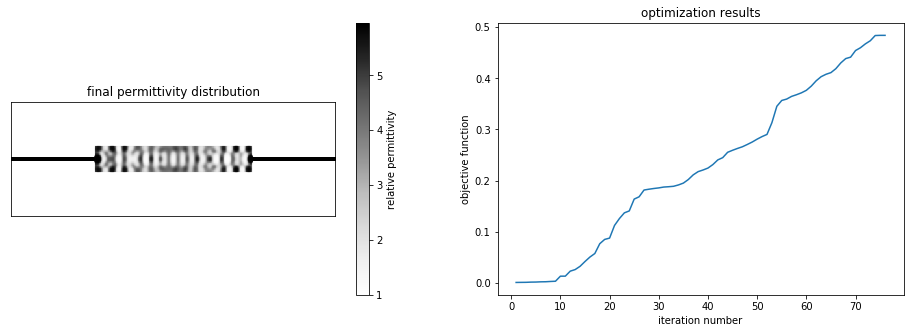

In [15]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))
simulation.plt_eps(ax=ax1, outline=False)
ax1.set_title('final permittivity distribution')
optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

the simulation did not converge, reached 0.451264175727924
the simulation did not converge, reached 0.4091646470650832


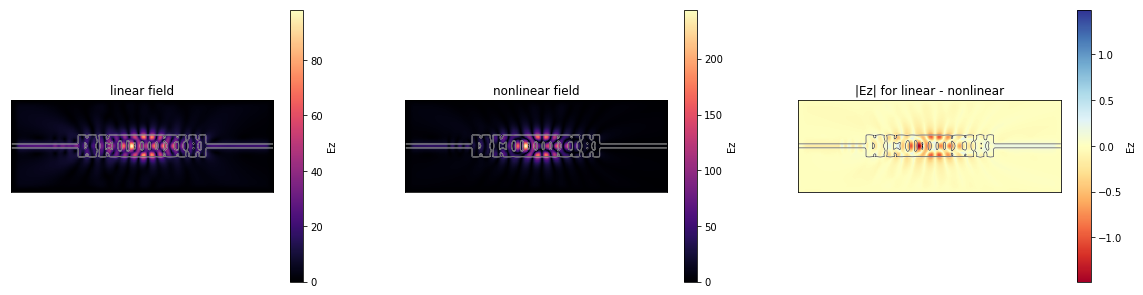

In [16]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=None)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=None, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

the simulation did not converge, reached 0.4512631179855121
the simulation did not converge, reached 0.4091646470657131
maximum refractive index shift of 0.012430330617118734


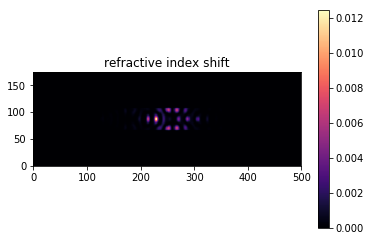

In [17]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

In [18]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2), nl=True)
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2), nl=True)

T_nl = W_out_nl/W_in

print('linear transmission              = {:.4f}'.format(T_lin))
print('nonlinear transmission           = {:.4f}\n'.format(T_nl))
print('relative power difference        = {:.2f} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('relative transmission difference = {:.2f} %'.format(100*abs(T_lin-T_nl)/T_lin))


the simulation did not converge, reached 0.45126460826045744
the simulation did not converge, reached 0.4091646470652088
linear transmission              = 0.5224
nonlinear transmission           = 0.0614

relative power difference        = 88.24 %
relative transmission difference = 88.24 %


 50% (25 of 50) |############            | Elapsed Time: 0:05:04 ETA:   0:48:46

the simulation did not converge, reached 0.7642502174767624


 52% (26 of 50) |############            | Elapsed Time: 0:07:01 ETA:   0:47:02

the simulation did not converge, reached 0.487246522355326


 54% (27 of 50) |############            | Elapsed Time: 0:08:59 ETA:   0:45:01

the simulation did not converge, reached 0.5171441020160055


 56% (28 of 50) |#############           | Elapsed Time: 0:10:56 ETA:   0:43:04

the simulation did not converge, reached 0.859144929243943


 57% (29 of 50) |#############           | Elapsed Time: 0:12:54 ETA:   0:41:09

the simulation did not converge, reached 0.35362456673870274


 90% (45 of 50) |#####################   | Elapsed Time: 0:19:06 ETA:   0:09:59

the simulation did not converge, reached 0.8415524340220236


 94% (47 of 50) |######################  | Elapsed Time: 0:21:24 ETA:   0:06:01

the simulation did not converge, reached 0.1075726992262326


 96% (48 of 50) |####################### | Elapsed Time: 0:23:24 ETA:   0:04:00

the simulation did not converge, reached 0.03858130206194818


 98% (49 of 50) |####################### | Elapsed Time: 0:25:25 ETA:   0:02:01

the simulation did not converge, reached 0.12472225874816671


100% (50 of 50) |########################| Elapsed Time: 0:27:26 ETA:  00:00:00

the simulation did not converge, reached 0.07370211897559399
the simulation did not converge, reached 0.05648652465830725


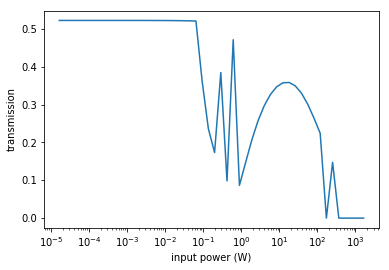

In [19]:
probe_out = lambda simulation: simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2), nl=True)
probes = [probe_out]
powers, transmissions = optimization.scan_power(probes=probes, Ns=50, s_min=1e-1, s_max=1e3)
for probe_index, _ in enumerate(probes):
    plt.plot(powers, transmissions[probe_index])
plt.xscale('log')
plt.xlabel('input power (W)')
plt.ylabel('transmission')
plt.show()

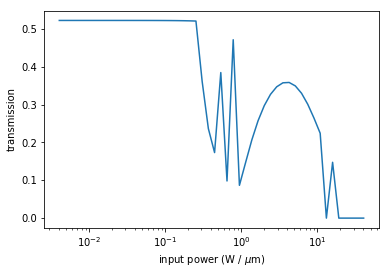

In [20]:
for probe_index, _ in enumerate(probes):
    plt.plot(np.sqrt(powers), transmissions[probe_index])
plt.xscale('log')
plt.xlabel('input power (W / $\mu$m)')
plt.ylabel('transmission')
plt.show()

 50% (50 of 100) |###########            | Elapsed Time: 0:05:10 ETA:   0:07:52

the simulation did not converge, reached 0.10170415311724634


 51% (51 of 100) |###########            | Elapsed Time: 0:05:46 ETA:   0:28:51

the simulation did not converge, reached 0.009238279179953067
the simulation did not converge, reached 0.25250554897241145


 52% (52 of 100) |###########            | Elapsed Time: 0:06:21 ETA:   0:28:16

the simulation did not converge, reached 0.06624772856297874
the simulation did not converge, reached 1.1467374985130915e-10


 53% (53 of 100) |############           | Elapsed Time: 0:06:56 ETA:   0:27:38

the simulation did not converge, reached 0.2519117812364024
the simulation did not converge, reached 0.5343929376806739


 54% (54 of 100) |############           | Elapsed Time: 0:07:31 ETA:   0:26:55

the simulation did not converge, reached 0.34300945409628864


100% (100 of 100) |######################| Elapsed Time: 0:16:46 ETA:  00:00:00

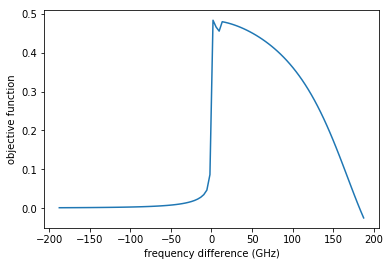

computed FWHM of 136.3636363635 (GHz):
Q factor of 1.10E+03


In [21]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=100, df=1/400)
optimization.simulation.omega = omega
plt.plot([(f-150e12)/1e9 for f in freqs], objs)
plt.xlabel('frequency difference (GHz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (GHz):'.format(FWHM/1e9))
print('Q factor of {0:.2E}'.format(omega/2/np.pi/FWHM))

loading in simulation and optimization...
    solving fields
the simulation did not converge, reached 0.45126384175386425
the simulation did not converge, reached 0.409164647066707
setting parameters...
setting geometry parameters...
generating data...
    computing index shift
the simulation did not converge, reached 0.45126466203219956
the simulation did not converge, reached 0.40916464706640243
        -> max index shift = [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
    computing power transmission
        -> W_in = 0.6587451220354704
        -> linear transmission              = 0.5224
        -> nonlinear transmission           = 0.0614
    computing frequency scan (100 points)
the simulation did not converge, reached 0.1017041566354909
the simulation did not converge, reached 0.00923827917990935
the simulation did not converge, reached 0.25250554246893814
the simulation

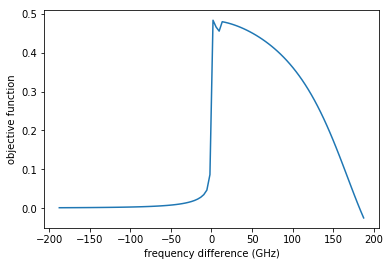

N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

        -> computed FWHM of 136.3636363635 (GHz):
        -> Q factor of 1.10E+03
    computing power scan (50 points)


 48% (24 of 50) |###########             | Elapsed Time: 0:05:02 ETA:   0:51:26

the simulation did not converge, reached 0.5123356250108441


 50% (25 of 50) |############            | Elapsed Time: 0:07:01 ETA:   0:49:33

the simulation did not converge, reached 0.7642502174743484


 56% (28 of 50) |#############           | Elapsed Time: 0:09:14 ETA:   0:43:31

the simulation did not converge, reached 0.8591449292425064


 57% (29 of 50) |#############           | Elapsed Time: 0:11:13 ETA:   0:41:30

the simulation did not converge, reached 0.3536245666017517


 90% (45 of 50) |#####################   | Elapsed Time: 0:17:22 ETA:   0:10:08

the simulation did not converge, reached 0.08172770597166723


 94% (47 of 50) |######################  | Elapsed Time: 0:19:40 ETA:   0:06:05

the simulation did not converge, reached 0.11634252945282468


 96% (48 of 50) |####################### | Elapsed Time: 0:21:42 ETA:   0:04:03

the simulation did not converge, reached 0.08112915766941287


 98% (49 of 50) |####################### | Elapsed Time: 0:23:44 ETA:   0:02:01

the simulation did not converge, reached 0.25476079230260085


100% (50 of 50) |########################| Elapsed Time: 0:25:45 ETA:  00:00:00

the simulation did not converge, reached 0.1510217133109658
the simulation did not converge, reached 0.17706731966412642


ValueError: 
\mum
^
Unknown symbol: \mum (at char 0), (line:1, col:1)

<Figure size 432x288 with 1 Axes>

the simulation did not converge, reached 0.1017040676171858
the simulation did not converge, reached 0.009238279179935891
the simulation did not converge, reached 0.25250556002700353
the simulation did not converge, reached 0.0662477285695031
the simulation did not converge, reached 1.1437570597981369e-10
the simulation did not converge, reached 0.2519117812363293
the simulation did not converge, reached 0.5343929354192838
the simulation did not converge, reached 0.343009454096957


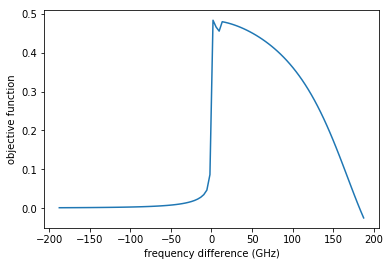

N/A% (0 of 50) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--

        -> computed FWHM of 136.3636363635 (GHz):
        -> Q factor of 1.10E+03


 48% (24 of 50) |###########             | Elapsed Time: 0:05:01 ETA:   0:51:26

the simulation did not converge, reached 0.5123356250118435


 50% (25 of 50) |############            | Elapsed Time: 0:07:00 ETA:   0:49:11

the simulation did not converge, reached 0.7642502174753173


 90% (45 of 50) |#####################   | Elapsed Time: 0:13:39 ETA:   0:10:06

the simulation did not converge, reached 0.11523692971118206


 92% (46 of 50) |######################  | Elapsed Time: 0:15:41 ETA:   0:08:05

the simulation did not converge, reached 0.25717958484071846


 96% (48 of 50) |####################### | Elapsed Time: 0:18:00 ETA:   0:04:02

the simulation did not converge, reached 0.07233641655090482


 98% (49 of 50) |####################### | Elapsed Time: 0:20:01 ETA:   0:02:01

the simulation did not converge, reached 0.09926994061377073


100% (50 of 50) |########################| Elapsed Time: 0:22:02 ETA:  00:00:00

the simulation did not converge, reached 0.051860822085660487
the simulation did not converge, reached 0.15598801087607567


ValueError: 
\mum
^
Unknown symbol: \mum (at char 0), (line:1, col:1)

<Figure size 432x288 with 1 Axes>

pickling device...
done


In [22]:
from data.device_saver import Device
D = Device(simulation, optimization)
D.set_parameters(lambda0, dl, NPML, chi3, eps_m, source_amp)
D.set_geometry('two_port', L, H, w, l, spc, dl, NPML, eps_m)
D.generate_data(Nf=100, Np=50)
D.freq_scan(Nf=100)
D.power_scan(Np=50, s_min=1e-1, s_max=1e3)
D.save('../data/figs/devices/2_port_alt.p')